<a href="https://colab.research.google.com/github/zulai98/AMD-project/blob/main/Analysing_Russia_Ukraine_Conflict_Twitter_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

1.   Get Dataset







In [1]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ["KAGGLE_USERNAME"] = "giulialob"
os.environ["KAGGLE_KEY"] = "d39799005be12f6ee0e278d0afddda99"

In [40]:
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows


ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip: Skipping, found more recently modified local copy (use --force to force download)




2.   Unzip and move Dataset



In [41]:
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip 

Archive:  ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip
  inflating: 0819_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0820_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0821_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0822_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0823_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0824_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0825_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0826_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0827_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0828_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0829_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0830_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0831_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0901_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0902_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0903_UkraineCombinedTweetsDeduped.csv.gzip  
  inflat

In [42]:
!mkdir UkrWar
!rm -rf sample_data

In [8]:
!gzip -l *.gzip


         compressed        uncompressed  ratio uncompressed_name
           12904715            34953892  63.1% 0819_UkraineCombinedTweetsDeduped.csv.gzip
           11555246            31061403  62.8% 0820_UkraineCombinedTweetsDeduped.csv.gzip
           12666569            33388881  62.1% 0821_UkraineCombinedTweetsDeduped.csv.gzip
           12630276            33832341  62.7% 0822_UkraineCombinedTweetsDeduped.csv.gzip
           13369828            35582191  62.4% 0823_UkraineCombinedTweetsDeduped.csv.gzip
           20484768            54244263  62.2% 0824_UkraineCombinedTweetsDeduped.csv.gzip
           15528348            41169048  62.3% 0825_UkraineCombinedTweetsDeduped.csv.gzip
           14596291            39188267  62.8% 0826_UkraineCombinedTweetsDeduped.csv.gzip
            9805376            26458798  62.9% 0827_UkraineCombinedTweetsDeduped.csv.gzip
            9554083            26180377  63.5% 0828_UkraineCombinedTweetsDeduped.csv.gzip
           14004266            3733

In [43]:
sh = """
for file in UkraineWar/UkraineWar/*.gzip; do
    mv "$file" UkrWar/"$(basename "$file" .gzip).gz"
done
for file in *.gzip; do
    mv "$file" UkrWar/"$(basename "$file".gzip).gz"
done
"""
with open('mv_script.sh', 'w') as file:
  file.write(sh)

!bash mv_script.sh

In [48]:
!rm -rf UkraineWar
!rm -rf sample_data

3. First sample -- Feb 27

In [47]:
#Find first date 
sh = """
cd UkrWar
(find $PWD -type f -iname "*FEB27*" )
"""
with open('find_feb_27_script.sh', 'w') as file:
  file.write(sh)

!bash find_feb_27_script.sh


/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz


In [ ]:
FILENAME='/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz.gz'

In [11]:
#Install Pyspark
%%capture
!pip install pyspark
!pip install findspark
!pip install spark-nlp==4.2.0


In [12]:
import numpy as np
import pandas as pd
import csv
import os
from pyspark.sql import SparkSession, Row
import random
import sparknlp
import math

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [13]:
# Build spark context
spark = sparknlp.start()
sc = spark.sparkContext

In [ ]:
# Loading the data from Market_Basket_Optimisation.csv inside the dataframe
raw_df = spark.read.csv(FILENAME, header=True, escape="\"", quote="\"", multiLine=True)


4. Exploratory Data Analysis

In [ ]:
raw_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- username: string (nullable = true)
 |-- acctdesc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- following: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- totaltweets: string (nullable = true)
 |-- usercreatedts: string (nullable = true)
 |-- tweetid: string (nullable = true)
 |-- tweetcreatedts: string (nullable = true)
 |-- retweetcount: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- language: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- extractedts: string (nullable = true)



In [ ]:
raw_df.show()

+-------+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|    _c0|             userid|       username|            acctdesc|            location|following|followers|totaltweets|       usercreatedts|            tweetid|     tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|         extractedts|
+-------+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|1141800|1466752038960656385| Curtin2Tiffany|I am just like ev...|       Colorado, USA|      253|       40|         94|20

In [ ]:
raw_df.show(n=5, truncate=False)

+-------+-------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+---------+-----------+--------------------------+-------------------+-------------------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------+--------------+--------------------------+
|_c0    |userid             |username       |acctdesc                                                                                   

In [ ]:
raw_df.select('language').distinct().show()

+--------+
|language|
+--------+
|      en|
|      ne|
|      vi|
|      ps|
|      ro|
|      sl|
|     und|
|      ur|
|      ka|
|      lv|
|      pl|
|      hy|
|      pt|
|    null|
|      tl|
|      in|
|      ko|
|      uk|
|      cs|
|     ckb|
+--------+
only showing top 20 rows



In [ ]:
raw_df.select('language').distinct().count()

63

In [ ]:
lang_dist=raw_df.groupby('language').count()
lang_dist.show()

+--------+------+
|language| count|
+--------+------+
|      en|227513|
|      ne|    15|
|      vi|    21|
|      ps|    10|
|      ro|   263|
|      sl|    38|
|     und| 13800|
|      ur|   526|
|      ka|    40|
|      lv|    40|
|      pl|  4505|
|      hy|     1|
|      pt|  2097|
|    null|     2|
|      tl|   138|
|      in|   560|
|      ko|   317|
|      uk|  1004|
|      cs|   275|
|     ckb|    16|
+--------+------+
only showing top 20 rows



In [ ]:
langdistribution=lang_dist.toPandas()
langdistribution=langdistribution.set_index("language")
langdistribution

,count
language,
en,227513
ne,15
vi,21
ps,10
ro,263
...,...
am,16
ja,3572
or,21


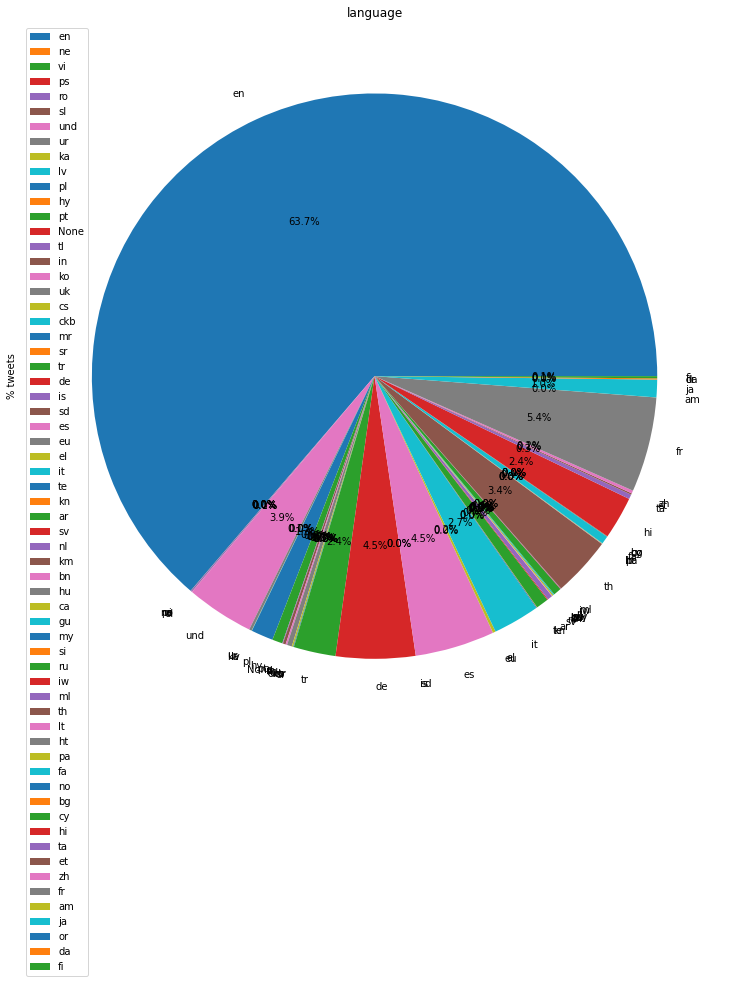

In [ ]:
pie = langdistribution.plot.pie(y = "count", figsize = (13,13), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "language", ylabel = "% tweets");

5. Restricting to English

In [ ]:
# Choose English -- most tweets
english_select=raw_df.where(raw_df.language == "en")

In [ ]:
english_select.show(truncate=False)

+-------+-------------------+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+---------+---------+-----------+--------------------------+-------------------+-------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------+--------------+--------------------------+
|_c0    |userid             |use

In [ ]:
filtered_df = english_select.select("text")

In [ ]:
filtered_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|#UkraineR

6. Define PreProcessing Pipeline

In [21]:
# In this step we define a sparkNLP pipeline which will preprocess our data
# by tokenizing it and removing unwanted tokens

from sparknlp.base import *
from sparknlp.annotator import *

def create_preprocessing_pipeline():
  documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
  tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
    #remove links
  linkRemover = Normalizer().setInputCols(["token"]).setOutputCol("tokensWoutLinks") \
  .setCleanupPatterns(["http\S+|www\S+|https\S+"]).setLowercase(True)#convert to lowercase
      #no whitespace or http (:)
    #[^\s]--keep spaces
    #[^\d]--keep numbers
    #[^\w]--keep letters
#remove punctuation
  punctuationRemover = Normalizer().setInputCols(["tokensWoutLinks"]).setOutputCol("tokensWoutLinksAndPuct") \
    .setCleanupPatterns(["&(amp)|@[A-Za-z0-9]+|[^\w ]|_|"])#regex remove all '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 
  #keep spaces
  stopWordsCleaner =  StopWordsCleaner.pretrained('stopwords_en', 'en').setInputCols("tokensWoutLinksAndPuct").setOutputCol("cleanedTokens")\
      .setCaseSensitive(False)
  stemmer = Stemmer().setInputCols(["cleanedTokens"]).setOutputCol("cleanedStemmedTokens")
  
  return Pipeline().setStages([
    documentAssembler,
    tokenizer,
    linkRemover,
    punctuationRemover,
    stopWordsCleaner,
    stemmer
])
def apply_preprocessing_pipeline(pipeline, dataframe):
    return pipeline.fit(dataframe).transform(dataframe).selectExpr("cleanedStemmedTokens.result")

In [ ]:
preprocessed_df=apply_preprocessing_pipeline(create_preprocessing_pipeline(),filtered_df)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [ ]:
preprocessed_df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[ukrainerussiawar, captur, russian, soldier, battalion, told, train, ukrain, russianarmi, soldier, ukrain, ukrainerussiawar]                                                                                                              |
|[root, ukrain, fight, russia, video, sad, soldier, 

6. Implement A-priori algorithm on sample

In [ ]:
#Remove duplicates
input_rdd = preprocessed_df.rdd.map(lambda x: ( list(set(x[0]))))#reorder
input_rdd.take(2)

[['train',
  'captur',
  'ukrain',
  'russianarmi',
  'battalion',
  'soldier',
  'ukrainerussiawar',
  'told',
  'russian'],
 ['clueless',
  'ukrain',
  'corrupt',
  'ukraineunderattack',
  'dictat',
  'vladimir',
  'fight',
  'dont',
  'soldier',
  'putin',
  'russia',
  'ukrainerussiawar',
  'ukrania',
  'forc',
  'lost',
  'sad',
  'video',
  'root']]

In [ ]:
#If needed --save to file to inspect
#!rm -rf itemsets.txt
#input_rdd.saveAsTextFile('itemsets.txt')

In [ ]:
n_of_baskets = input_rdd.count()#countlenght
MIN_SUPPORT_PERC = 0.2
MIN_SUPPORT = math.ceil(n_of_baskets * MIN_SUPPORT_PERC)


In [ ]:
MIN_SUPPORT

45503

In [ ]:

#FREQUENT SINGLETONS

singleton_itemsets_rdd = input_rdd.flatMap(lambda x:x).map(lambda x: (x,1))

# Compute frequencies using a reduce operation --count
singleton_itemsets_w_frequencies_rdd = singleton_itemsets_rdd.reduceByKey(lambda x,y: x + y)

# Filter singletons with a frequency higher than THRESHOLD
frequent_singleton_itemsets_rdd = singleton_itemsets_w_frequencies_rdd.map(lambda x: (x[0], x[1])).filter(lambda x: x[1] > MIN_SUPPORT)

# These are examples of frequent singleton itemsets with the relative frequency
frequent_singleton_itemsets_rdd.take(10)


[('ukrain', 163217), ('russian', 63249), ('putin', 46503), ('russia', 83932)]

In [ ]:
frequents_RDD= frequent_singleton_itemsets_rdd.map(lambda x:x[0])  
frequents_RDD.take(10)##this must not be empty ..first 10 elemnts

['ukrain', 'russian', 'putin', 'russia']

**Important functions**
<br>**Get All Possible Candidates(frequent_k-1_set, n)**
<br>Generate all the possible k-candidates from the previous frequent (k-1)candidate itemset (where k>1)
<br>**count_candidates(transaction_set, candidates_k_set)**
<br>Equivalent to a filter and map function. Filter applied on whether the item is present in the initial transaction list, map (yes=1, no=0).
<br>Will perform a flatMap(count_candidates(itemset,get_all_possible_candidates))


In [14]:
import itertools
def get_all_possible_candidates(frequents,n):#all possible combo.
  frequents=frequents.collect()#all of them
  #Get all of the single items -- remove duplicates
  if (n==2):#receive singlets
    singles = set()
    for item in frequents:#for item
      singles.add(item)#add if unique
    
  if (n>2):#will recieve n-uplets (split)
    singles=set() 
    for itemsets in frequents: 
      for item in itemsets: #Get each individual item>
        singles.add(item) 
  
  print(singles)
  #Combine single to form n-uples (no repetition)      
  candidates=[set(itemsets) for itemsets in list(itertools.combinations(singles, n))] 
  print(candidates)
  return candidates

In [15]:
#If given candidate (e.g. combo of item) is a subset of the initial transaction set then append 1 -- if freq
def count_candidates(transaction_set, candidates):
    c_list = []
    for itemsets in candidates:
        print(itemsets)                     
        if set(list(itemsets)).issubset(set(transaction_set)):#if candidate 
            c_list.append([tuple(itemsets), 1])
            print(c_list)
        else:
            c_list.append([tuple(itemsets), 0])
    return c_list

In [16]:
def get_frequent_itemsets(candidates, itemsets_rdd, MIN_SUPPORT):
    frequent_item_set = itemsets_rdd.flatMap(lambda x: count_candidates(x, candidates)).reduceByKey(lambda a, b: a+b).map(lambda x: x).filter(lambda x: x[1]>=MIN_SUPPORT)
    return frequent_item_set

In [ ]:
candidate_sets = get_all_possible_candidates(frequents_RDD, 2)

{'putin', 'russia', 'ukrain', 'russian'}
[{'putin', 'russia'}, {'putin', 'ukrain'}, {'putin', 'russian'}, {'russia', 'ukrain'}, {'russia', 'russian'}, {'ukrain', 'russian'}]


In [ ]:
len(candidate_sets)##6 possible comb (4!/(2!*2!))

6

In [ ]:
candidate_sets

[{'putin', 'russia'},
 {'putin', 'ukrain'},
 {'putin', 'russian'},
 {'russia', 'ukrain'},
 {'russia', 'russian'},
 {'russian', 'ukrain'}]

In [ ]:
frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)

In [ ]:
frequents_pair_RDD = frequent_itemsets.map(lambda x:x[0])

In [ ]:
frequent_itemsets.take(5)

[(('russia', 'ukrain'), 63693), (('ukrain', 'russian'), 49165)]

In [ ]:
frequents_pair_RDD.take(5)

[('russia', 'ukrain'), ('ukrain', 'russian')]

In [ ]:
candidate_sets = get_all_possible_candidates(frequents_pair_RDD, 3)#items --list

{'russia', 'russian', 'ukrain'}
[{'russia', 'russian', 'ukrain'}]


In [ ]:
frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)

In [ ]:
frequents_trip_RDD = frequent_itemsets.map(lambda x:x[0])


In [ ]:
frequents_trip_RDD.take(10)

[]

7. Experiments -- size/support vs runtime, trends in user tendencies

Get specific date shell script

In [51]:
sh = """
specialformat=true
if  [ $1 = "02" ]
then
  var="FEB"
  echo $var
elif  [ $1 = "03" ]
then
  var="MAR"
  echo $var
else
  specialformat=false
fi
if $specialformat
then
  (find $PWD -type f -iname "*$var$2*" )|tee out
else
  (find $PWD -type f -iname "*$1$2*" )|tee out
fi

"""
with open('find_file_data.sh', 'w') as file:
  file.write(sh)

**Additional important functions**
<br>**not_empty(freq_sets)**
<br>If frequent k-set is not empty return True 

In [17]:
#Generate a priori algorithm
  #need a while loop
def not_empty(freq_sets):
    return (freq_sets.count() > 0) and (freq_sets is not None)

**Putting everything together in the following functions:**
<br>- **apriori(input_rdd,MIN_SUPPORT)**
<br> *Find frequent 1->k-uple items using Apriori*
<br>- **apply_preprocessing_pipeline(pipeline, dataframe)**
<br> *applying the preprocessing pipeline to the selected dataframe*
<br>- **generate_results(FILENAME, preprocessing_pipeline, THRESHOLD_PERCENTAGE)**
<br> *Generate the results (frequent k-uples) for a specific filename (and a given preprocessing pipeline)*

In [67]:
def apriori(input_rdd,MIN_SUPPORT):
      
   tweet_freqRDD=(input_rdd.flatMap(lambda x:x).map(lambda i: (i, 1)).reduceByKey(lambda a,b: a+b))
   ##Frequent_items_and_count_RDD shall be used to saveall the frequent items from 1->k
   frequent_items_and_count_RDD= tweet_freqRDD.map(lambda x: (x[0], x[1])).filter(lambda x: x[1]>=MIN_SUPPORT)    
   frequent_items_RDD= frequent_items_and_count_RDD.map(lambda x:x[0])
   n=2
   input_rdd.cache()#taken several times
   frequent_itemsets_list = sc.parallelize([])
   frequent_itemsets_list+=frequent_items_RDD  

   while not_empty(frequent_items_RDD):
     
     candidate_sets = get_all_possible_candidates(frequent_items_RDD, n)
     frequent_itemsets = get_frequent_itemsets(candidate_sets, input_rdd, MIN_SUPPORT)
     frequent_items_RDD = frequent_itemsets.map(lambda x:x[0])
     #Save all the frequent items from 1->k
     frequent_itemsets_list += frequent_items_RDD
#     frequent_items_and_count_RDD  = frequent_items_and_count_RDD.union(frequent_itemsets)
   
     n += 1
   input_rdd.unpersist()#once i found all the frequent (1 to k)uples then unpersist
   return frequent_itemsets_list

In [20]:
def apply_preprocessing_pipeline(pipeline, dataframe):
    return pipeline.fit(dataframe).transform(dataframe).selectExpr("cleanedStemmedTokens.result")

In [53]:
#Try to get a story out of the different tweets
# for FEB28 we specify only part1

def generate_results(FILENAME, preprocessing_pipeline, THRESHOLD_PERCENTAGE):

  # Reading and filtering the dataset acc.g to language
  raw_df = spark.read.csv(FILENAME, header=True, escape="\"", quote="\"", multiLine=True)
  filtered_df = raw_df.where(raw_df.language == "en").select("text")

  # Apply preprocessing pipeline to dataframe.
  preprocessed_df = apply_preprocessing_pipeline(preprocessing_pipeline,filtered_df)
  # Preparing the RDD for the a_priori_algorithm
  input_rdd = preprocessed_df.rdd.map(lambda x: (list(set(x[0]))))

  # Defining the threshold
  n_of_baskets = input_rdd.count()#countlenght -> 227,513 (rows)
  print('No of tweets are ', n_of_baskets)
  THRESHOLD = math.ceil(n_of_baskets * THRESHOLD_PERCENTAGE)
  print('Min support is ' , THRESHOLD)
  # Print the runtime, return frequent 1-kuple 
  import time 
  start_time = time.time()
  result = apriori(input_rdd, THRESHOLD)
  end_time = time.time()
  print('Runtime is' , end_time - start_time)

  return result

In [72]:
# Defining the pipeline once (donwload stopwords only once)
preprocessing_pipeline = create_preprocessing_pipeline()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


27th of February - support_percentage = 0.05

In [73]:
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_27_02_C005=generate_results(PATHNAME, preprocessing_pipeline,0.05)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz
No of tweets are  227513
Min support is  11376
{'russian', 'militari', 'russia', 'peopl', 'war', 'anonym', 'countri', 'kyiv', 'support', 'standwithukrain', 'ukrainian', 'ukrainerussiawar', 'ukrainewar', 'ukrain', 'ukraineunderattack', 'world', 'putin', 'russiaukrainewar'}
[{'russian', 'militari'}, {'russian', 'russia'}, {'russian', 'peopl'}, {'war', 'russian'}, {'anonym', 'russian'}, {'russian', 'countri'}, {'russian', 'kyiv'}, {'russian', 'support'}, {'russian', 'standwithukrain'}, {'russian', 'ukrainian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'ukrainewar'}, {'russian', 'ukrain'}, {'ukraineunderattack', 'russian'}, {'russian', 'world'}, {'russian', 'putin'}, {'russian', 'russiaukrainewar'}, {'militari', 'russia'}, {'militari', 'peopl'}, {'war', 'militari'}, {'anonym', 'militari'}, {'countri', 'militari'}, {'militari', 'kyiv'}, {'militari', 'support'}, {'militari', 'standwithukrain'}, {'militari', 'ukrainian'}, {'mil

In [74]:
result_27_02_C005.collect()

['ukrain',
 'ukrainerussiawar',
 'russian',
 'ukraineunderattack',
 'putin',
 'russia',
 'ukrainian',
 'kyiv',
 'peopl',
 'world',
 'war',
 'russiaukrainewar',
 'ukrainewar',
 'anonym',
 'standwithukrain',
 'support',
 'militari',
 'countri',
 ('russia', 'russian'),
 ('ukrainian', 'russian'),
 ('ukrain', 'russian'),
 ('putin', 'russian'),
 ('russia', 'war'),
 ('russia', 'ukrainian'),
 ('russia', 'ukrain'),
 ('putin', 'russia'),
 ('peopl', 'ukrain'),
 ('ukrain', 'war'),
 ('anonym', 'ukrain'),
 ('countri', 'ukrain'),
 ('ukrain', 'kyiv'),
 ('ukrain', 'support'),
 ('ukrain', 'ukrainian'),
 ('ukrainerussiawar', 'ukrain'),
 ('ukrainewar', 'ukrain'),
 ('ukrain', 'ukraineunderattack'),
 ('ukrain', 'world'),
 ('putin', 'ukrain'),
 ('russia', 'ukrain', 'russian'),
 ('ukrain', 'ukrainian', 'russian'),
 ('russia', 'ukrain', 'war'),
 ('russia', 'ukrain', 'ukrainian'),
 ('putin', 'russia', 'ukrain')]

27th of February - support_percentage = 0.1



In [75]:
#Focus on one day (largest) -- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_27_02_C01=generate_results(PATHNAME, preprocessing_pipeline,0.1)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz
No of tweets are  227513
Min support is  22752
{'russian', 'russia', 'peopl', 'war', 'kyiv', 'ukrainian', 'ukrainerussiawar', 'ukrain', 'putin'}
[{'russian', 'russia'}, {'russian', 'peopl'}, {'war', 'russian'}, {'russian', 'kyiv'}, {'russian', 'ukrainian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'russia', 'peopl'}, {'war', 'russia'}, {'kyiv', 'russia'}, {'ukrainian', 'russia'}, {'ukrainerussiawar', 'russia'}, {'russia', 'ukrain'}, {'russia', 'putin'}, {'war', 'peopl'}, {'kyiv', 'peopl'}, {'ukrainian', 'peopl'}, {'ukrainerussiawar', 'peopl'}, {'ukrain', 'peopl'}, {'putin', 'peopl'}, {'war', 'kyiv'}, {'war', 'ukrainian'}, {'war', 'ukrainerussiawar'}, {'war', 'ukrain'}, {'war', 'putin'}, {'kyiv', 'ukrainian'}, {'kyiv', 'ukrainerussiawar'}, {'kyiv', 'ukrain'}, {'kyiv', 'putin'}, {'ukrainian', 'ukrainerussiawar'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'putin'}, {'ukrainerussiawar', 'ukrain

In [76]:
result_27_02_C01.collect()

['ukrain',
 'ukrainerussiawar',
 'russian',
 'putin',
 'russia',
 'ukrainian',
 'kyiv',
 'peopl',
 'war',
 ('russia', 'russian'),
 ('ukrain', 'russian'),
 ('russia', 'ukrain'),
 ('ukrain', 'war'),
 ('ukrain', 'ukrainian'),
 ('putin', 'ukrain')]

27th of February - support_percentage = 0.15

In [77]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_27_02_C015=generate_results(PATHNAME, preprocessing_pipeline,0.15)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz
No of tweets are  227513
Min support is  34127
{'russian', 'russia', 'ukrainian', 'ukrain', 'putin'}
[{'russian', 'russia'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'russia', 'putin'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'putin'}, {'putin', 'ukrain'}]
{'russian', 'russia', 'ukrain'}
[{'russian', 'russia', 'ukrain'}]
Runtime is 612.6119410991669


In [78]:
result_27_02_C015.collect()

['ukrain',
 'russian',
 'putin',
 'russia',
 'ukrainian',
 ('ukrain', 'russian'),
 ('russia', 'ukrain')]

27th of February - support_percentage = 0.2

In [79]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_27_02_C02=generate_results(PATHNAME, preprocessing_pipeline,0.2)

FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz
No of tweets are  227513
Min support is  45503
{'russia', 'russian', 'putin', 'ukrain'}
[{'russian', 'russia'}, {'russia', 'putin'}, {'russia', 'ukrain'}, {'russian', 'putin'}, {'russian', 'ukrain'}, {'putin', 'ukrain'}]
{'russian', 'russia', 'ukrain'}
[{'russian', 'russia', 'ukrain'}]
Runtime is 578.6665155887604


In [80]:
result_27_02_C02.collect()

['ukrain',
 'russian',
 'putin',
 'russia',
 ('russia', 'ukrain'),
 ('ukrain', 'russian')]

27th of February - support_percentage = 0.25

In [81]:
#Focus on one day (largest)-- but vary LIMIT--record time (take 5 measures). Find best compromise for future ones
#find file
!rm out
!bash find_file_data.sh 02 27
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_27_02_C03=generate_results(PATHNAME, preprocessing_pipeline,0.3)


FEB
/content/UkrWar/UkraineCombinedTweetsDeduped_FEB27.csv.gz
No of tweets are  227513
Min support is  68254
{'russia', 'ukrain'}
[{'russia', 'ukrain'}]
Runtime is 558.7506256103516


In [82]:
result_27_02_C03.collect()

['ukrain', 'russia']

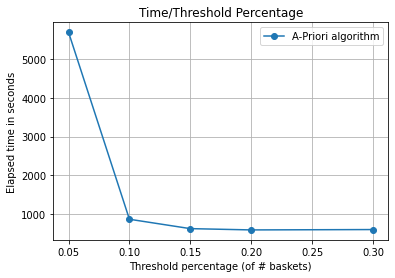

In [4]:
#for feb 27
#68254 Runtime is 1164.8368389606476 (.3)
#45503 Runtime is 1277.746163368225 (.2)
#34127 Runtime is 1318.6258103847504 (.15)
#22752 Runtime is 1856.7753727436066 (.1)
#11376 Runtime is 10375.439755678177 (.05)

import matplotlib.pyplot as plt
#threshold=[68254,45503,34127,22752,11376]
threshold_perc=[.3,.2,.15,.1,.05]
elapsed_time=[589,579.7,613,856,5703]

time_threshold_perc_ratio = pd.DataFrame()
time_threshold_perc_ratio['Elapsed_time'] = elapsed_time
time_threshold_perc_ratio['Threshold'] = threshold_perc
plt.plot(time_threshold_perc_ratio['Threshold'], time_threshold_perc_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', marker = 'o')
plt.xlabel('Threshold percentage (of # baskets)')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_threshold_perc_ratio.jpg')
plt.legend()
plt.grid()
plt.title('Time/Threshold Percentage')
plt.show()

Settle on a BEST_MIN_SUPPORT

In [84]:
BEST_MIN_SUPPORT=0.1

In [85]:
#          278455064           732598840  62.0% UkraineCombinedTweetsDeduped20220227-131611.csv
#          82892498           209652014  60.5% UkraineCombinedTweetsDeduped_FEB27.csv
#          35812015            97510321  63.3% 0722_UkraineCombinedTweetsDeduped.csv
#          28378314            72450067  60.8% 0921_UkraineCombinedTweetsDeduped.csv.gzip
#          14550285            38189130  61.9% 1005_UkraineCombinedTweetsDeduped.csv.gzip
#          12507492            33878722  63.1% 0818_UkraineCombinedTweetsDeduped.csv


6th of March - support_percentage = 0.1

In [86]:
!rm out
!bash find_file_data.sh 03 06
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_06_03_C01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

MAR
/content/UkrWar/UkraineCombinedTweetsDeduped_MAR06.csv.gz
No of tweets are  396249
Min support is  39625
{'russian', 'russia', 'weapon', 'stop', 'war', 'civilian', 'peopl', 'provid', 'innoc', 'standwithukrain', 'ukrainian', 'defend', 'ukrainerussianwar', 'humanitarian', 'ukrain', 'putin'}
[{'russian', 'russia'}, {'russian', 'weapon'}, {'russian', 'stop'}, {'war', 'russian'}, {'russian', 'civilian'}, {'russian', 'peopl'}, {'russian', 'provid'}, {'russian', 'innoc'}, {'russian', 'standwithukrain'}, {'russian', 'ukrainian'}, {'russian', 'defend'}, {'russian', 'ukrainerussianwar'}, {'russian', 'humanitarian'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'russia', 'weapon'}, {'russia', 'stop'}, {'war', 'russia'}, {'russia', 'civilian'}, {'russia', 'peopl'}, {'provid', 'russia'}, {'innoc', 'russia'}, {'russia', 'standwithukrain'}, {'ukrainian', 'russia'}, {'defend', 'russia'}, {'ukrainerussianwar', 'russia'}, {'russia', 'humanitarian'}, {'russia', 'ukrain'}, {'russia', 'putin'}, {'weap

In [87]:
result_06_03_C01.collect()

['russia',
 'russian',
 'putin',
 'ukrain',
 'stop',
 'war',
 'ukrainian',
 'innoc',
 'provid',
 'weapon',
 'defend',
 'humanitarian',
 'civilian',
 'peopl',
 'ukrainerussianwar',
 'standwithukrain',
 ('ukrain', 'russian'),
 ('russia', 'ukrain'),
 ('stop', 'ukrain'),
 ('putin', 'stop'),
 ('ukrain', 'civilian'),
 ('provid', 'ukrain'),
 ('humanitarian', 'ukrain'),
 ('putin', 'ukrain')]

7th of April - support_percentage = 0.1

In [88]:
!rm out
#month -day
!bash find_file_data.sh 04 07
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_07_04_C01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0407_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  259123
Min support is  25913
{'russian', 'russia', 'peopl', 'war', 'standwithukrain', 'ukrainian', 'bucha', 'ukrain'}
[{'russian', 'russia'}, {'russian', 'peopl'}, {'war', 'russian'}, {'russian', 'standwithukrain'}, {'russian', 'ukrainian'}, {'russian', 'bucha'}, {'russian', 'ukrain'}, {'russia', 'peopl'}, {'war', 'russia'}, {'russia', 'standwithukrain'}, {'ukrainian', 'russia'}, {'bucha', 'russia'}, {'russia', 'ukrain'}, {'war', 'peopl'}, {'standwithukrain', 'peopl'}, {'ukrainian', 'peopl'}, {'bucha', 'peopl'}, {'ukrain', 'peopl'}, {'war', 'standwithukrain'}, {'war', 'ukrainian'}, {'war', 'bucha'}, {'war', 'ukrain'}, {'ukrainian', 'standwithukrain'}, {'bucha', 'standwithukrain'}, {'ukrain', 'standwithukrain'}, {'ukrainian', 'bucha'}, {'ukrainian', 'ukrain'}, {'bucha', 'ukrain'}]
{'russian', 'ukrainian', 'russia', 'ukrain'}
[{'russian', 'ukrainian', 'russia'}, {'russian', 'ukrainian', 'ukrain'}, {'russian', 'rus

In [89]:
result_07_04_C01.collect()

['peopl',
 'ukrain',
 'russia',
 'war',
 'standwithukrain',
 'ukrainian',
 'bucha',
 'russian',
 ('ukrain', 'russian'),
 ('russia', 'ukrain'),
 ('ukrain', 'ukrainian')]

16th of May - support_percentage = 0.1

In [90]:
!rm out
!bash find_file_data.sh 05 16
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_16_05_C01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0516_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  258309
Min support is  25831
{'russian', 'russia', 'ukrainian', 'ukrain', 'tigrai'}
[{'russian', 'russia'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'russian', 'tigrai'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'russia', 'tigrai'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'tigrai'}, {'tigrai', 'ukrain'}]
{'russian', 'ukrain'}
[]
Runtime is 816.6065902709961


In [91]:
result_16_05_C01.collect()

['ukrain', 'ukrainian', 'russia', 'russian', 'tigrai', ('ukrain', 'russian')]

10th of June - support_percentage = 0.1

In [92]:
!rm out
!bash find_file_data.sh 06 10
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_10_06_C01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0610_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  182985
Min support is  18299
{'russian', 'russia', 'war', 'ukrainian', 'ukrain', 'tigrai'}
[{'russian', 'russia'}, {'war', 'russian'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'russian', 'tigrai'}, {'war', 'russia'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'russia', 'tigrai'}, {'war', 'ukrainian'}, {'war', 'ukrain'}, {'war', 'tigrai'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'tigrai'}, {'tigrai', 'ukrain'}]
{'russian', 'ukrainian', 'russia', 'ukrain'}
[{'russian', 'ukrainian', 'russia'}, {'russian', 'ukrainian', 'ukrain'}, {'russian', 'russia', 'ukrain'}, {'ukrainian', 'russia', 'ukrain'}]
Runtime is 624.6565210819244


In [93]:
result_10_06_C01.collect()

['war',
 'ukrain',
 'ukrainian',
 'russia',
 'russian',
 'tigrai',
 ('ukrain', 'russian'),
 ('russia', 'ukrain'),
 ('ukrain', 'ukrainian')]

22nd of July - support_percentage = 0.1

In [94]:
!rm out
!bash find_file_data.sh 07 22
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      result_22_07_C01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0722_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  88929
Min support is  8893
{'russian', 'russia', 'war', 'standwithukrain', 'ukrainian', 'ukrain', 'world', 'putin'}
[{'russian', 'russia'}, {'war', 'russian'}, {'russian', 'standwithukrain'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'russian', 'world'}, {'russian', 'putin'}, {'war', 'russia'}, {'russia', 'standwithukrain'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'world', 'russia'}, {'russia', 'putin'}, {'war', 'standwithukrain'}, {'war', 'ukrainian'}, {'war', 'ukrain'}, {'war', 'world'}, {'war', 'putin'}, {'ukrainian', 'standwithukrain'}, {'ukrain', 'standwithukrain'}, {'world', 'standwithukrain'}, {'putin', 'standwithukrain'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'world'}, {'ukrainian', 'putin'}, {'world', 'ukrain'}, {'putin', 'ukrain'}, {'world', 'putin'}]
{'russian', 'russia', 'ukrain'}
[{'russian', 'russia', 'ukrain'}]
Runtime is 311.36044931411743


In [95]:
result_22_07_C01.collect()

['russia',
 'ukrain',
 'war',
 'russian',
 'putin',
 'ukrainian',
 'standwithukrain',
 'world',
 ('ukrain', 'russian'),
 ('russia', 'ukrain')]

18th of August - support_percentage = 0.1

In [96]:
!rm out
!bash find_file_data.sh 08 18
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_08_18_C_01 = generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0818_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  22991
Min support is  2300
{'russian', 'russia', 'war', 'ukrainian', 'ukrain'}
[{'russian', 'russia'}, {'war', 'russian'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'war', 'russia'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'war', 'ukrainian'}, {'war', 'ukrain'}, {'ukrainian', 'ukrain'}]
{'russia', 'ukrain'}
[]
Runtime is 64.48895788192749


In [97]:
results_08_18_C_01.collect()

['ukrain', 'russia', 'russian', 'ukrainian', 'war', ('russia', 'ukrain')]

18th of August - support_percentage = 0.05 (small dataset)

In [98]:
!rm out
!bash find_file_data.sh 08 18
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_18_08_C_005=generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/0818_UkraineCombinedTweetsDeduped.csv.gz
No of tweets are  22991
Min support is  1150
{'russian', 'militari', 'russiaisateroristst', 'russia', 'china', 'peopl', 'war', 'russiaisaterroristst', 'standwithukrain', 'ukrainian', 'ukrainerussiawar', 'biden', 'ukrain', 'putin'}
[{'russian', 'militari'}, {'russian', 'russiaisateroristst'}, {'russian', 'russia'}, {'russian', 'china'}, {'russian', 'peopl'}, {'war', 'russian'}, {'russian', 'russiaisaterroristst'}, {'russian', 'standwithukrain'}, {'russian', 'ukrainian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'biden'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'militari', 'russiaisateroristst'}, {'militari', 'russia'}, {'militari', 'china'}, {'militari', 'peopl'}, {'war', 'militari'}, {'militari', 'russiaisaterroristst'}, {'militari', 'standwithukrain'}, {'militari', 'ukrainian'}, {'militari', 'ukrainerussiawar'}, {'militari', 'biden'}, {'militari', 'ukrain'}, {'militari', 'putin'}, {'russia', 'russiaisateroristst'}, {'c

In [99]:
results_18_08_C_005.collect()

['ukrain',
 'russia',
 'russian',
 'militari',
 'biden',
 'putin',
 'standwithukrain',
 'russiaisaterroristst',
 'ukrainian',
 'war',
 'china',
 'russiaisateroristst',
 'peopl',
 'ukrainerussiawar',
 ('russia', 'russian'),
 ('ukrain', 'russian'),
 ('russia', 'ukrain'),
 ('ukrain', 'war'),
 ('ukrain', 'ukrainian')]

21st of September - support_percentage = 0.1

In [100]:
!rm out
!bash find_file_data.sh 09 21
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_21_09_C_01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/0921_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  47859
Min support is  4786
{'russian', 'russia', 'war', 'ukrainerussiawar', 'ukrain', 'putin'}
[{'russian', 'russia'}, {'war', 'russian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'war', 'russia'}, {'ukrainerussiawar', 'russia'}, {'russia', 'ukrain'}, {'russia', 'putin'}, {'war', 'ukrainerussiawar'}, {'war', 'ukrain'}, {'war', 'putin'}, {'ukrainerussiawar', 'ukrain'}, {'ukrainerussiawar', 'putin'}, {'putin', 'ukrain'}]
{'russia', 'putin', 'ukrain'}
[{'russia', 'putin', 'ukrain'}]
Runtime is 137.04011249542236


In [101]:
results_21_09_C_01.collect()

['ukrain',
 'war',
 'putin',
 'russia',
 'russian',
 'ukrainerussiawar',
 ('russia', 'ukrain'),
 ('putin', 'russia'),
 ('putin', 'ukrain')]

21st of September - support_percentage = 0.05 (smaller dataset)

In [102]:
!rm out
!bash find_file_data.sh 09 21
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_21_09_C_005=generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/0921_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  47859
Min support is  2393
{'russian', 'russia', 'peopl', 'war', 'mobil', 'ukrainian', 'ukrainerussiawar', 'biden', 'ukrain', 'world', 'putin'}
[{'russian', 'russia'}, {'russian', 'peopl'}, {'war', 'russian'}, {'russian', 'mobil'}, {'russian', 'ukrainian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'biden'}, {'russian', 'ukrain'}, {'russian', 'world'}, {'russian', 'putin'}, {'russia', 'peopl'}, {'war', 'russia'}, {'mobil', 'russia'}, {'ukrainian', 'russia'}, {'ukrainerussiawar', 'russia'}, {'biden', 'russia'}, {'russia', 'ukrain'}, {'world', 'russia'}, {'russia', 'putin'}, {'war', 'peopl'}, {'mobil', 'peopl'}, {'ukrainian', 'peopl'}, {'ukrainerussiawar', 'peopl'}, {'biden', 'peopl'}, {'ukrain', 'peopl'}, {'world', 'peopl'}, {'putin', 'peopl'}, {'war', 'mobil'}, {'war', 'ukrainian'}, {'war', 'ukrainerussiawar'}, {'war', 'biden'}, {'war', 'ukrain'}, {'war', 'world'}, {'war', 'putin'}, {'ukrainian', 'm

In [103]:
results_21_09_C_005.collect()

['ukrain',
 'war',
 'putin',
 'russia',
 'biden',
 'russian',
 'ukrainerussiawar',
 'ukrainian',
 'world',
 'mobil',
 'peopl',
 ('russia', 'russian'),
 ('ukrain', 'russian'),
 ('putin', 'russian'),
 ('russia', 'war'),
 ('russia', 'mobil'),
 ('ukrainerussiawar', 'russia'),
 ('russia', 'ukrain'),
 ('putin', 'russia'),
 ('ukrain', 'war'),
 ('putin', 'war'),
 ('ukrainerussiawar', 'ukrain'),
 ('putin', 'ukrain'),
 ('putin', 'russia', 'ukrain')]

5th of October - support_percentage = 0.1

In [104]:
!rm out
!bash find_file_data.sh 10 05
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_05_10_C_01=generate_results(PATHNAME, preprocessing_pipeline,BEST_MIN_SUPPORT)

/content/UkrWar/1005_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  25546
Min support is  2555
{'russian', 'russia', 'war', 'ukrainian', 'ukrain', 'putin'}
[{'russian', 'russia'}, {'war', 'russian'}, {'russian', 'ukrainian'}, {'russian', 'ukrain'}, {'russian', 'putin'}, {'war', 'russia'}, {'ukrainian', 'russia'}, {'russia', 'ukrain'}, {'russia', 'putin'}, {'war', 'ukrainian'}, {'war', 'ukrain'}, {'war', 'putin'}, {'ukrainian', 'ukrain'}, {'ukrainian', 'putin'}, {'putin', 'ukrain'}]
{'russian', 'russia', 'ukrain'}
[{'russian', 'russia', 'ukrain'}]
Runtime is 84.84578037261963


In [105]:
results_05_10_C_01.collect()

['ukrain',
 'war',
 'russia',
 'russian',
 'putin',
 'ukrainian',
 ('ukrain', 'russian'),
 ('russia', 'ukrain')]

5th of October - support_percentage = 0.05

In [106]:
!rm out
!bash find_file_data.sh 10 05
with open('out', 'r') as file:
    PATHNAME = file.readline().strip()
    if(PATHNAME == ''):
      print("Data not found -- exit")
    else:
      results_05_10_C_005=generate_results(PATHNAME, preprocessing_pipeline,0.05)

/content/UkrWar/1005_UkraineCombinedTweetsDeduped.csv.gzip.gzip.gz
No of tweets are  25546
Min support is  1278
{'region', 'russian', 'russia', 'war', 'standwithukrain', 'forc', 'ukrainian', 'ukrainerussiawar', 'putin', 'ukrain', 'kherson', 'world', 'ukrainewar', 'nato'}
[{'region', 'russian'}, {'region', 'russia'}, {'war', 'region'}, {'region', 'standwithukrain'}, {'forc', 'region'}, {'region', 'ukrainian'}, {'region', 'ukrainerussiawar'}, {'region', 'putin'}, {'region', 'ukrain'}, {'kherson', 'region'}, {'region', 'world'}, {'region', 'ukrainewar'}, {'region', 'nato'}, {'russian', 'russia'}, {'war', 'russian'}, {'russian', 'standwithukrain'}, {'forc', 'russian'}, {'russian', 'ukrainian'}, {'russian', 'ukrainerussiawar'}, {'russian', 'putin'}, {'russian', 'ukrain'}, {'kherson', 'russian'}, {'russian', 'world'}, {'russian', 'ukrainewar'}, {'russian', 'nato'}, {'war', 'russia'}, {'russia', 'standwithukrain'}, {'forc', 'russia'}, {'ukrainian', 'russia'}, {'ukrainerussiawar', 'russia'}, {

In [107]:
results_05_10_C_005.collect()

['ukrain',
 'kherson',
 'standwithukrain',
 'war',
 'russia',
 'region',
 'ukrainerussiawar',
 'russian',
 'forc',
 'nato',
 'ukrainewar',
 'putin',
 'ukrainian',
 'world',
 ('russia', 'russian'),
 ('ukrain', 'russian'),
 ('putin', 'russia'),
 ('russia', 'ukrain'),
 ('ukrain', 'war'),
 ('ukrain', 'ukrainian'),
 ('putin', 'ukrain')]

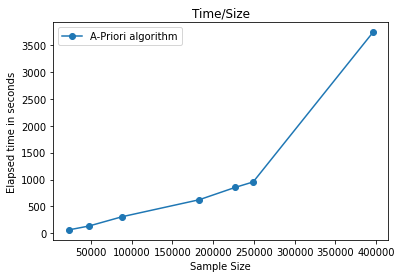

In [3]:
import pandas as pd
##Larger datasets
#feb 22,752 - 1856.8 ---find a lot of words
#mar 39,625 - 2835.2 -----find a lot of words

##Avg datasets
#apr 25,913 - 768.7 
#may 25,813 - 646.52
#jun 18,299 - 496.02
#jul  8,893 -253.820 

##Considerably smaller dataset -- can incr support perc given runtime.
#aug  2,300 -62.7 
#sep  4,786 - 119.0
#oct  2,555 - 64.93
import matplotlib.pyplot as plt
samplesize=[396249, 249227,227513, 182985, 88929, 47859, 22911]
elapsed_time=[3736,955.5,856.0,624.7,311.3,137.0,64.5]

time_threshold_ratio = pd.DataFrame()
time_threshold_ratio['Elapsed_time'] = elapsed_time
time_threshold_ratio['Sample Size'] = samplesize
plt.plot(time_threshold_ratio['Sample Size'], time_threshold_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', marker = 'o')
plt.xlabel('Sample Size')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_size.jpg')
plt.legend()
plt.title('Time/Size')
plt.show()